In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

# Presentazione del problema

Questo progetto ha l'obiettivo di separare un'immagine, ottenuta come somma di due immagini, nelle sue componenti originali.

Le due immagini di origine, img1 e img2, provengono da dataset diversi: MNIST e Fashion-MNIST, rispettivamente.

Senza alcuna pre-elaborazione, la rete neurale riceve in input l'immagine combinata (img1 + img2) e restituisce le predizioni (hat_img1 e hat_img2).

Le prestazioni vengono valutate utilizzando l'errore quadratico medio (MSE) tra le immagini predette e quelle di riferimento.

Entrambi i dataset (MNIST e Fashion-MNIST) sono in scala di grigi. Per semplicità, tutti i campioni vengono adattati alla risoluzione (32,32).

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 32, 32)


In [3]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Qui di seguito un semplice generatore dei dati.

In [4]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Definiamo un generatore con batchsize=1 e visualizziamo qualche dato.

In [5]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Osserviamo qualche coppia input-output.

In [6]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

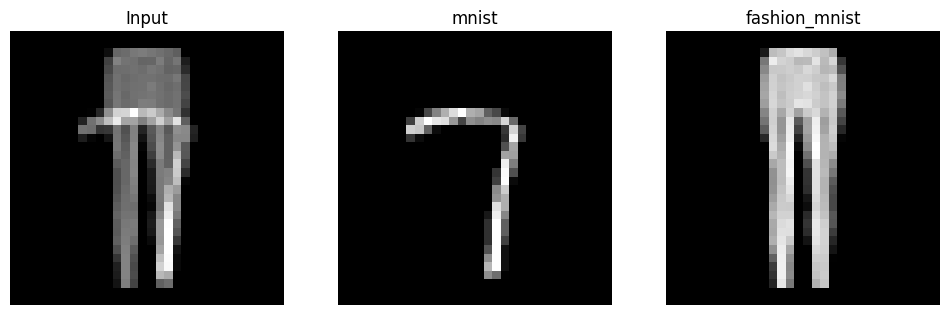

In [7]:
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

# Valutazione delle prestazioni

Definiano un generatore di test con batchsize 5000.

In [8]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

Testiamo un semplice modello che predice due volte l'immagine presa in input.

In [9]:
def ide_model(x):
   return((x,x))

In [10]:
def eval_model(model):
  x, (y1,y2) = next(testgen)

  
  pred1,pred2 = model(x)



# FUNZIONE GIUSTA DA USARE PER LA VALUTAZIONE DELL'ERRORE
  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2

In [11]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(ide_model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mse =  0.03625551098022698
standard deviation =  0.0002404718898016436


# Definizione del modello (DeepSplit)

In [12]:
def create_separation_model():
    """
    Crea un modello di rete neurale per la separazione di immagini sovrapposte.

    Architettura:
    - Encoder condiviso che estrae features da immagini combinate
    - Due decoder separati per ricostruire le immagini MNIST e Fashion-MNIST
    - Utilizza skip connections per preservare i dettagli spaziali
    - Batch normalization per stabilizzare il training

    Returns:
        Model: Modello Keras compilato
    """
    # Input layer (32x32 immagine in scala di grigi)
    input_img = layers.Input(shape=(32, 32))
    # Reshape per aggiungere il canale (richiesto per Conv2D)
    x = layers.Reshape((32, 32, 1))(input_img)

    def efficient_block_with_skip(x, filters):
        """
        Blocco di convoluzione efficiente con skip connection.

        Caratteristiche:
        - Usa conv 1x1 per ridurre i parametri
        - Conv 3x3 per feature extraction
        - Skip connection per migliorare il flusso del gradiente
        - Batch normalization per training più stabile

        Args:
            x: Input tensor
            filters: Numero di filtri di output
        """
        skip = x  # Salva input per skip connection

        # Conv 1x1 per ridurre la dimensionalità (bottleneck)
        # Riduce il numero di parametri e il costo computazionale
        x = layers.Conv2D(filters//2, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # Conv 3x3 per l'estrazione delle features
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # Skip connection se le dimensioni corrispondono
        # Aiuta con il problema del vanishing gradient
        if skip.shape[-1] == filters:
            x = layers.Add()([x, skip])
        return x

    # Encoder
    # Aumenta progressivamente il numero di filtri per catturare features più complesse
    x = efficient_block_with_skip(x, 64)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = efficient_block_with_skip(x, 128)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = efficient_block_with_skip(x, 256)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder per MNIST
    # Struttura simmetrica all'encoder per ricostruzione ottimale
    x1 = efficient_block_with_skip(encoded, 256)
    x1 = layers.UpSampling2D((2, 2))(x1)

    x1 = efficient_block_with_skip(x1, 128)
    x1 = layers.UpSampling2D((2, 2))(x1)

    x1 = efficient_block_with_skip(x1, 64)
    x1 = layers.UpSampling2D((2, 2))(x1)

    # Output layer con sigmoid per normalizzare i valori tra 0 e 1
    x1 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x1)
    decoded_mnist = layers.Reshape((32, 32))(x1)

    # Decoder per Fashion-MNIST
    # Struttura simile ma con parametri indipendenti
    x2 = efficient_block_with_skip(encoded, 192)
    x2 = layers.UpSampling2D((2, 2))(x2)

    x2 = efficient_block_with_skip(x2, 96)
    x2 = layers.UpSampling2D((2, 2))(x2)

    x2 = efficient_block_with_skip(x2, 48)
    x2 = layers.UpSampling2D((2, 2))(x2)

    x2 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x2)
    decoded_fashion = layers.Reshape((32, 32))(x2)

    # Crea il modello con input condiviso e due output
    model = tf.keras.Model(input_img, [decoded_mnist, decoded_fashion])

    # Configurazione dell'ottimizzatore
    # - Learning rate più alto (2e-3) per convergenza più rapida
    # - Beta1 aumentato a 0.95 per momentum più aggressivo
    # - Beta2 standard per adattamento dei learning rate individuali
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=2e-3,
        beta_1=0.95,  # Aumentato da 0.9 per momentum più forte
        beta_2=0.999,
        epsilon=1e-08
    )

    # Compila il modello con MSE come loss function
    model.compile(optimizer=optimizer, loss='mse')

    return model


# Training del modello

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 32, 1)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │             64 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 1,111,978 (4.24 MB)

 Trainable params: 1,108,282 (4.23 MB)

 Non-trainable params: 3,696 (14.44 KB)

Epoch 1/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - loss: 0.0395 - reshape_1_loss: 0.0200 - reshape_2_loss: 0.0195 - learning_rate: 0.0020
Epoch 2/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0143 - reshape_1_loss: 0.0054 - reshape_2_loss: 0.0089 - learning_rate: 0.0020
Epoch 3/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0120 - reshape_1_loss: 0.0044 - reshape_2_loss: 0.0076 - learning_rate: 0.0020
Epoch 4/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0107 - reshape_1_loss: 0.0039 - reshape_2_loss: 0.0068 - learning_rate: 0.0020
Epoch 5/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0099 - reshape_1_loss: 0.0036 - reshape_2_loss: 0.0063 - learning_rate: 0.0020
Epoch 6/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0091 - reshape_1_loss: 0.0033 - reshape_2_loss: 0.0058 - learning_rate: 0.0020
Epoch 7/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0087 - reshape_1_loss: 0.0032 - reshape_2_loss: 0.0056 - learning_rate:

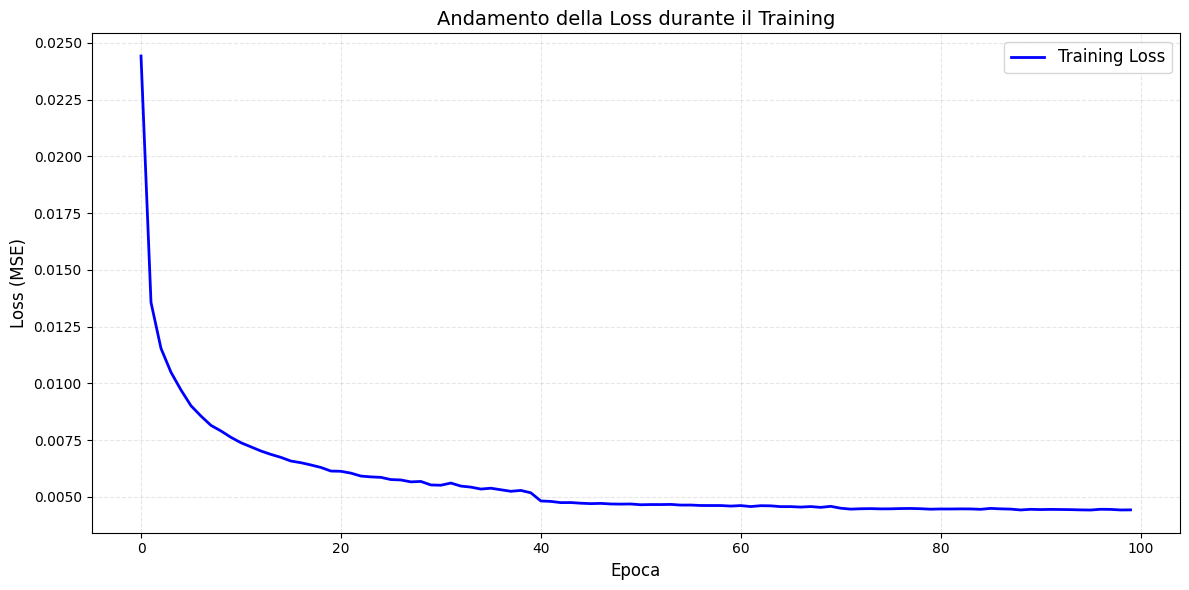

In [13]:
# Parametri di training
batchsize = 64  # Dimensione del batch - bilancia velocità di training e uso memoria
epochs = 100    # Numero di epoche totali per l'addestramento

def lr_schedule(epoch):
    """
    Schedule del learning rate con decadimento graduale.
    Riduce il learning rate in modo progressivo per affinare l'apprendimento.

    Args:
        epoch: epoca corrente
    Returns:
        learning rate appropriato per l'epoca
    """
    initial_lr = 2e-3  # Learning rate iniziale

    # Schedule di decadimento del learning rate:
    # - Prime 40 epoche: learning rate pieno per esplorazione iniziale
    # - 40-70 epoche: riduzione a 15% per raffinamento
    # - 70-90 epoche: ulteriore riduzione a 3% per fine-tuning
    # - >90 epoche: riduzione finale a 0.5% per micro-aggiustamenti
    if epoch < 40:
        return initial_lr
    elif epoch < 70:
        return initial_lr * 0.15
    elif epoch < 90:
        return initial_lr * 0.03
    else:
        return initial_lr * 0.005

# Configurazione dei callbacks per ottimizzare il training
callbacks = [
    # Salvataggio del modello migliore
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',        # Nome del file di salvataggio
        monitor='loss',            # Monitora la loss
        save_best_only=True,       # Salva solo se migliore del precedente
        mode='min'                 # Minimizza la loss
    ),

    # Early stopping per evitare overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',            # Monitora la loss
        patience=30,               # Aspetta 30 epoche prima di fermarsi
        restore_best_weights=True  # Ripristina i pesi migliori
    ),

    # Learning rate scheduler
    tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

# Creazione e compilazione del modello
model = create_separation_model()
model.summary()

# Creazione del generator per il training
train_gen = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize)

# Training del modello
history = model.fit(
    train_gen,                                    # Generator dei dati
    steps_per_epoch=len(mnist_x_train) // batchsize,  # Passi per epoca
    epochs=epochs,                                # Numero totale di epoche
    callbacks=callbacks                           # Callbacks configurati
)

# Visualizzazione della loss durante il training
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.title('Andamento della Loss durante il Training', fontsize=14)
plt.xlabel('Epoca', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)


# Personalizzazione del grafico
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Valutazione del modello addestrato, con alcuni esempi

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE medio =  0.0022212818913474354
Deviazione standard =  1.621850267336919e-05
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


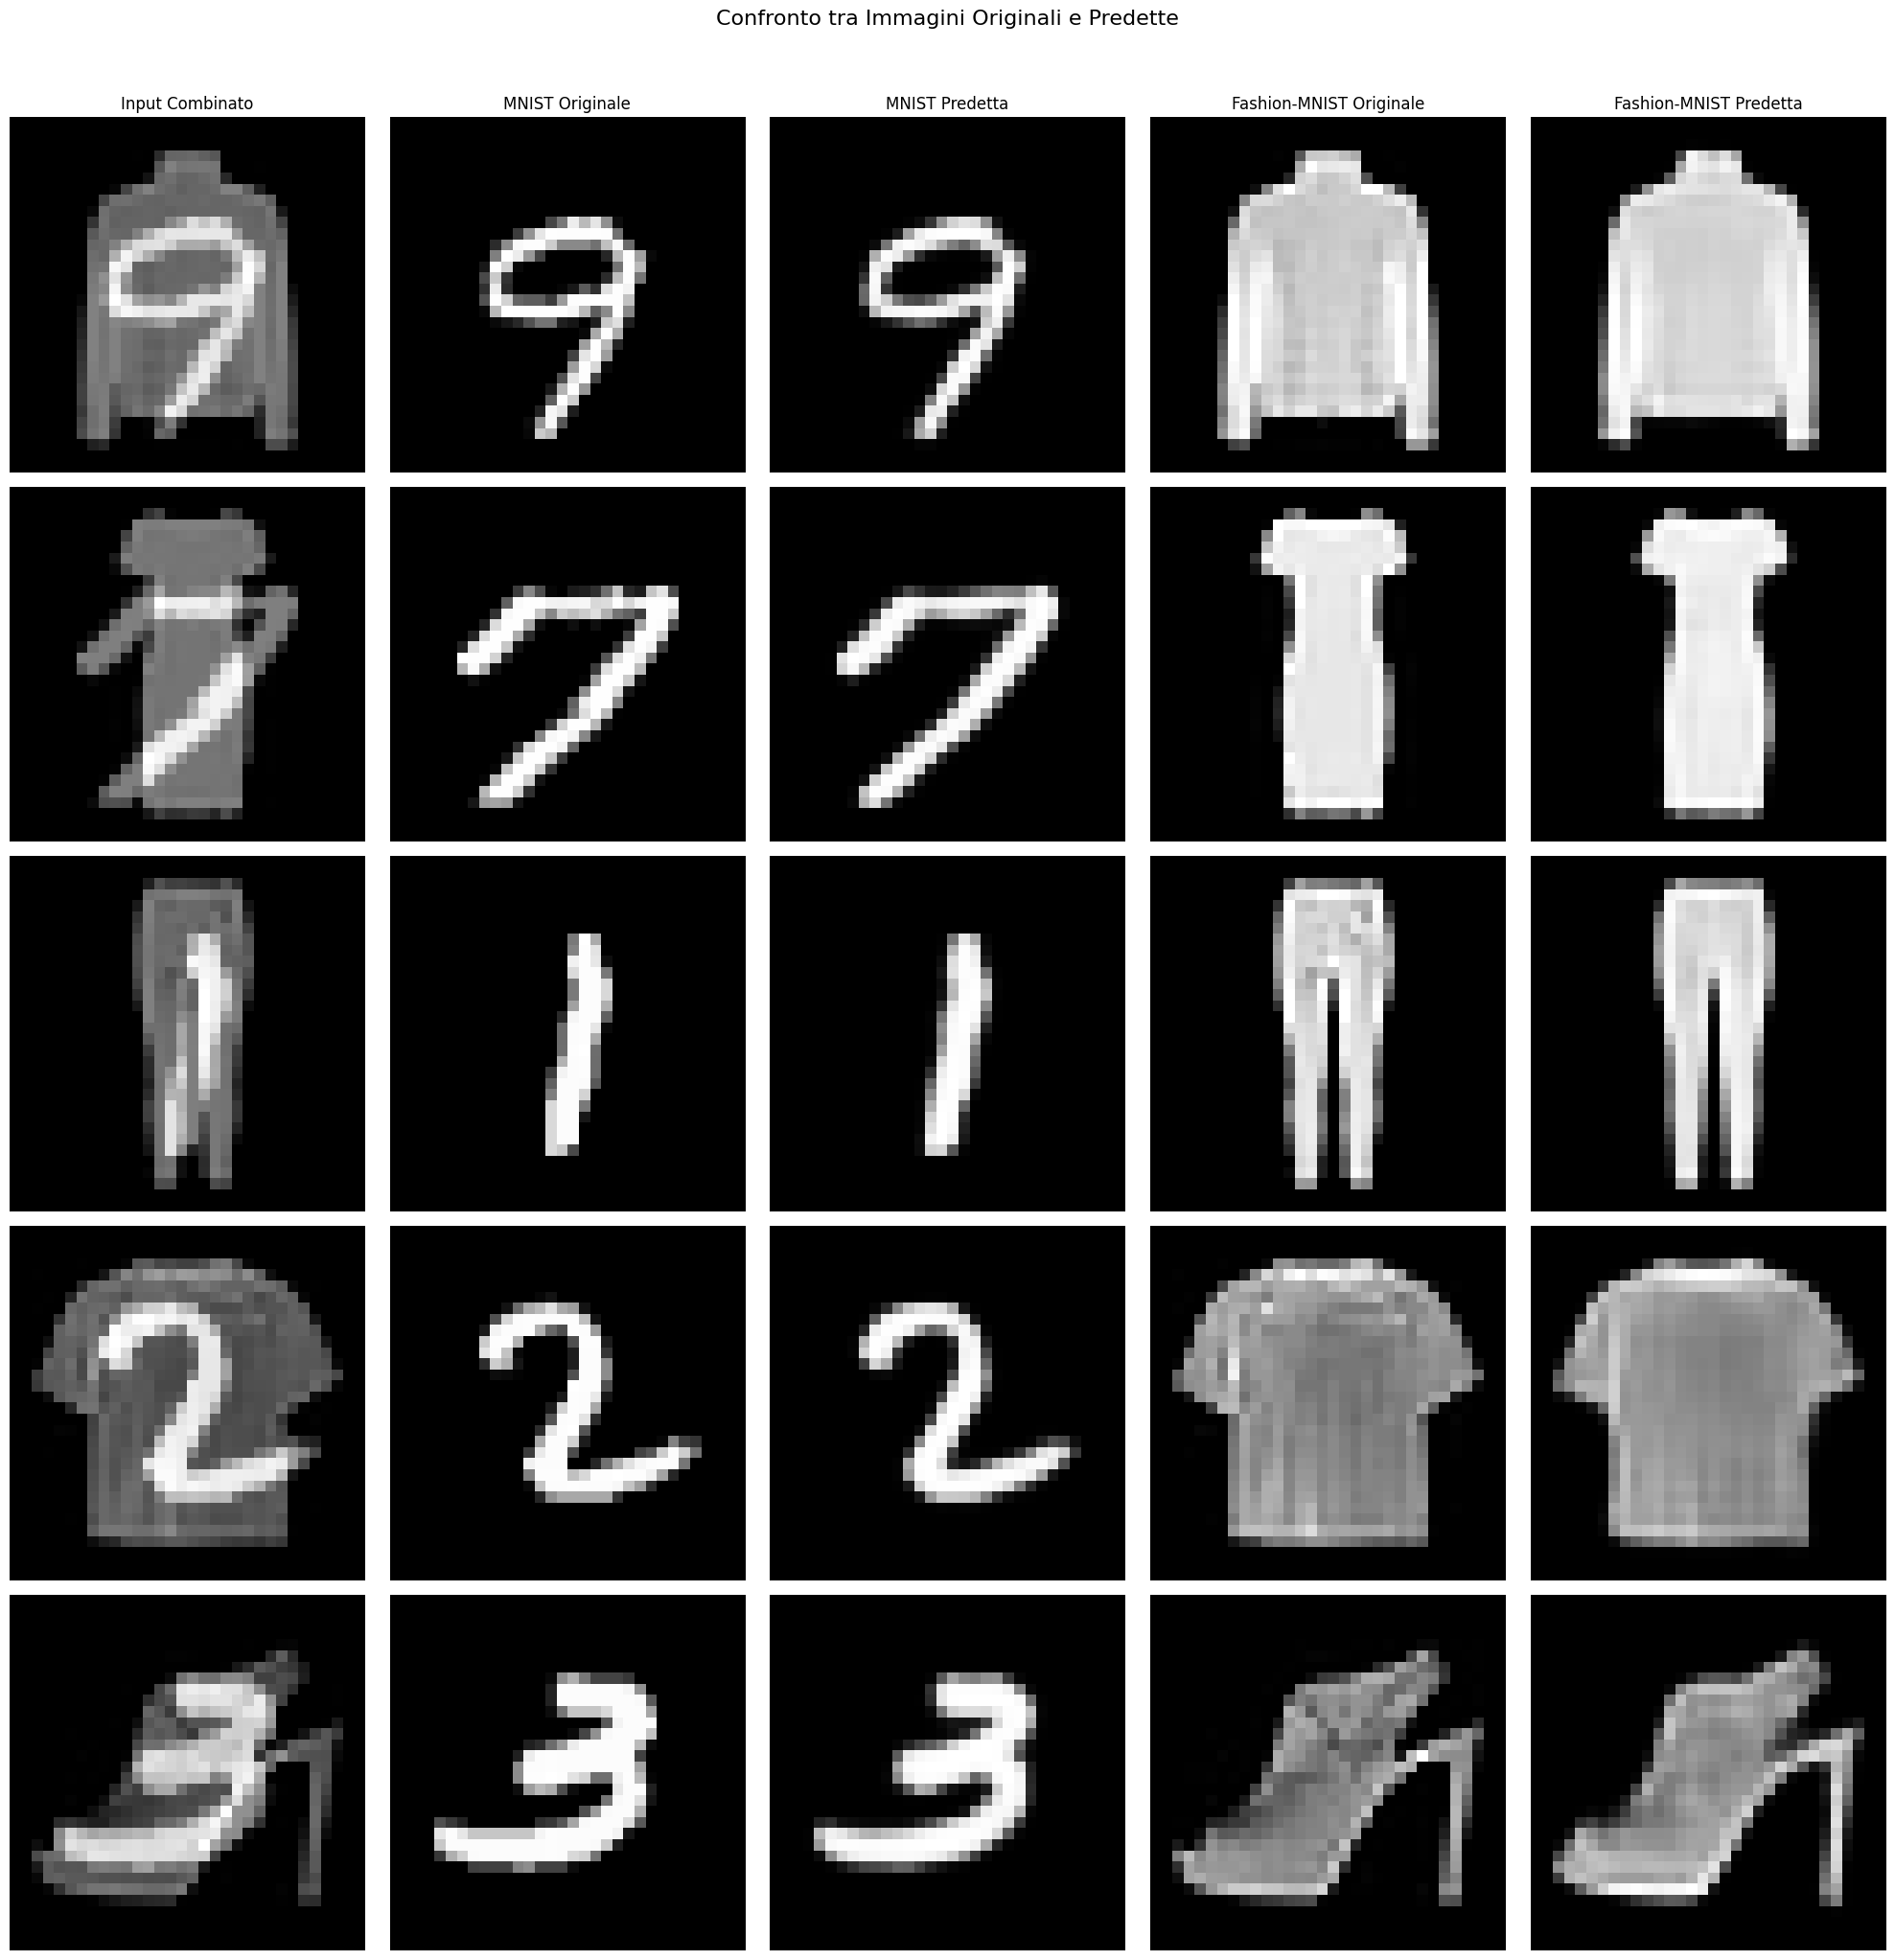


Analisi dell'errore per ogni esempio:

Esempio 1:
MNIST:
  - MSE: 0.001013
Fashion-MNIST:
  - MSE: 0.000830
MSE medio dell'esempio: 0.000922

Esempio 2:
MNIST:
  - MSE: 0.001604
Fashion-MNIST:
  - MSE: 0.000976
MSE medio dell'esempio: 0.001290

Esempio 3:
MNIST:
  - MSE: 0.000650
Fashion-MNIST:
  - MSE: 0.000797
MSE medio dell'esempio: 0.000724

Esempio 4:
MNIST:
  - MSE: 0.000998
Fashion-MNIST:
  - MSE: 0.001693
MSE medio dell'esempio: 0.001345

Esempio 5:
MNIST:
  - MSE: 0.001841
Fashion-MNIST:
  - MSE: 0.003036
MSE medio dell'esempio: 0.002439


In [14]:
# Definiamo una funzione wrapper per le predizioni del modello
def trained_model_predict(x):
    """
    Funzione wrapper per standardizzare l'interfaccia delle predizioni.
    Necessaria per mantenere compatibilità con la funzione eval_model.

    Args:
        x: batch di immagini combinate
    Returns:
        tuple: (predizioni MNIST, predizioni Fashion-MNIST)
    """
    predictions = model.predict(x)
    return predictions

# Valutiamo le prestazioni del modello
repeat_eval = 10  # Numero di valutazioni per ottenere una stima robusta
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(trained_model_predict))

# Stampiamo le metriche di performance
print("MSE medio = ", np.mean(eval_results))
print("Deviazione standard = ", np.std(eval_results))

# Otteniamo un nuovo batch di test per la visualizzazione
x, (y1, y2) = next(testgen)
pred1, pred2 = model.predict(x)

# Mostriamo più esempi per una valutazione qualitativa
num_examples = 5  # Numero di esempi da visualizzare
random_indices = np.random.choice(len(x), num_examples, replace=False)

# Creiamo un subplot per ogni esempio (5 righe, 5 colonne)
fig, axes = plt.subplots(num_examples, 5, figsize=(20, 4*num_examples))

# Alziamo il titolo principale e aggiungiamo padding
plt.suptitle('Confronto tra Immagini Originali e Predette',
             fontsize=16,
             y=1.02)  # y>1 sposta il titolo sopra la figura

for i, idx in enumerate(random_indices):
    # Input combinato
    axes[i,0].imshow(x[idx], cmap='gray')
    axes[i,0].set_title('Input Combinato' if i == 0 else '')
    axes[i,0].axis('off')

    # MNIST originale
    axes[i,1].imshow(y1[idx], cmap='gray')
    axes[i,1].set_title('MNIST Originale' if i == 0 else '')
    axes[i,1].axis('off')

    # MNIST predetta
    axes[i,2].imshow(pred1[idx], cmap='gray')
    axes[i,2].set_title('MNIST Predetta' if i == 0 else '')
    axes[i,2].axis('off')

    # Fashion-MNIST originale
    axes[i,3].imshow(y2[idx], cmap='gray')
    axes[i,3].set_title('Fashion-MNIST Originale' if i == 0 else '')
    axes[i,3].axis('off')

    # Fashion-MNIST predetta
    axes[i,4].imshow(pred2[idx], cmap='gray')
    axes[i,4].set_title('Fashion-MNIST Predetta' if i == 0 else '')
    axes[i,4].axis('off')

plt.tight_layout()
plt.show()


# Analisi dell'errore per ogni esempio
print("\nAnalisi dell'errore per ogni esempio:")
for i, idx in enumerate(random_indices):
    print(f"\nEsempio {i+1}:")
    # MSE per MNIST
    mse_mnist = np.mean((pred1[idx] - y1[idx])**2)
    print(f"MNIST:")
    print(f"  - MSE: {mse_mnist:.6f}")

    # MSE per Fashion-MNIST
    mse_fashion = np.mean((pred2[idx] - y2[idx])**2)
    print(f"Fashion-MNIST:")
    print(f"  - MSE: {mse_fashion:.6f}")

    # MSE medio per questo esempio
    print(f"MSE medio dell'esempio: {(mse_mnist + mse_fashion)/2:.6f}")